<a href="https://colab.research.google.com/github/Rojan116/NepaliHandWrittenAlphabetRecognizer/blob/master/59_class_cnn_with_augmented_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Change runtime to GPU for faster compuatation

# Prepare the dataset
Download dataset from [this url](https://archive.ics.uci.edu/ml/machine-learning-databases/00389/). 

In [0]:
# get dataset from url
! wget -qq https://archive.ics.uci.edu/ml/machine-learning-databases/00389/DevanagariHandwrittenCharacterDataset.zip

# unzip zip files
!unzip -q DevanagariHandwrittenCharacterDataset.zip

# rename directory
!mv DevanagariHandwrittenCharacterDataset/ data/ 
# remove .zip file
!rm *.zip

In [2]:
ls

data/  sample_data/


In [3]:
!git clone https://github.com/Rojan116/NepaliHandWrittenAlphabetRecognizer.git

Cloning into 'NepaliHandWrittenAlphabetRecognizer'...
remote: Enumerating objects: 8014, done.
remote: Counting objects: 100% (8014/8014), done.
remote: Compressing objects: 100% (7981/7981), done.
remote: Total 105545 (delta 160), reused 7878 (delta 32), pack-reused 97531
Receiving objects: 100% (105545/105545), 139.63 MiB | 8.49 MiB/s, done.
Resolving deltas: 100% (1710/1710), done.
Checking out files: 100% (106170/106170), done.


In [4]:
ls

data/  NepaliHandWrittenAlphabetRecognizer/  sample_data/


In [5]:
cd NepaliHandWrittenAlphabetRecognizer

/content/NepaliHandWrittenAlphabetRecognizer


In [6]:
ls

augmented_cnn_36_class.ipynb   nepalibarna/
augmented_cnn.ipynb            nepalibarnasnew/
augmented_cnn_predicted.ipynb  new_cnn_9766_acc.ipynb
Augmented_Nepali_Digits.ipynb  new_cnn_98%.ipynb
cnn_98_.ipynb                  new_cnn.ipynb
CNN.ipynb                      new_cnn_may14.ipynb
custom_model.ipynb             new_cnn_may15.ipynb
dev.py                         new_cnn_may16.ipynb
dhrcdata/                      new_own_cnn.ipynb
image_augmentation.ipynb       own_dataset_cnn.ipynb
keras_to_tfliteipynb.ipynb     size.py
my_own_cnn_for_mnist.ipynb     Untitled.ipynb


#Load libraries 

In [0]:
# import libraries
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, callbacks, optimizers, models
import os
from keras.layers import *
from keras.optimizers import *

In [0]:
PATH = os.getcwd()
DATADIR = PATH + '/nepalibarnasnew/Train'		
train_data_path = PATH + '/nepalibarnasnew/Train'
test_data_path = PATH + '/nepalibarnasnew/Test'


In [0]:
# for this problem i'll consider only digits
class_names = [

"character_1_ka","character_2_kha","character_3_ga","character_4_gha","character_5_kna",
"character_6_cha","character_7_chha","character_8_ja","character_9_jha","character_10_yna",
"character_11_taamatar","character_12_thaa","character_13_daa","character_14_dhaa","character_15_adna",
"character_16_tabala","character_17_tha","character_18_da","character_19_dha","character_20_na","character_21_pa",
"character_22_pha","character_23_ba","character_24_bha","character_25_ma","character_26_yaw","character_27_ra",
"character_28_la","character_29_waw","character_30_motosaw","character_31_petchiryakha","character_32_patalosaw",
"character_33_ha","character_34_chhya","character_35_tra","character_36_gya","digit_0","digit_1","digit_2","digit_3",
"digit_4","digit_5","digit_6","digit_7","digit_8","digit_9","vowel_0_a","vowel_1_aa","vowel_2_i","vowel_3_ii","vowel_4_u",
"vowel_5_uu","vowel_6_re","vowel_7_e","vowel_8_ei","vowel_9_o","vowel_10_au","vowel_11_am","vowel_12_ah"

]


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                              zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                              zoom_range=0.)

In [80]:
train_digits_loader = train_datagen.flow_from_directory(
        'nepalibarnasnew/Train',
        target_size=(32, 32),
        classes = class_names,
        batch_size=32,
        color_mode = 'grayscale',
        class_mode='categorical')

test_digits_loader = test_datagen.flow_from_directory(
        'nepalibarnasnew/Test',
        target_size=(32, 32),
        classes = class_names,
        color_mode = 'grayscale',
        batch_size=1,
        shuffle = False,
        seed = 2076,
        class_mode='categorical')

Found 1756 images belonging to 59 classes.
Found 130 images belonging to 59 classes.


# Visualize Data

In [0]:
def plot_image(img_path_index):
  img_path = train_digits_loader.filepaths[img_path_index]
  a = Image.open(img_path)
  arr = np.array(a)
  plt.imshow(arr,cmap= 'gray')
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])


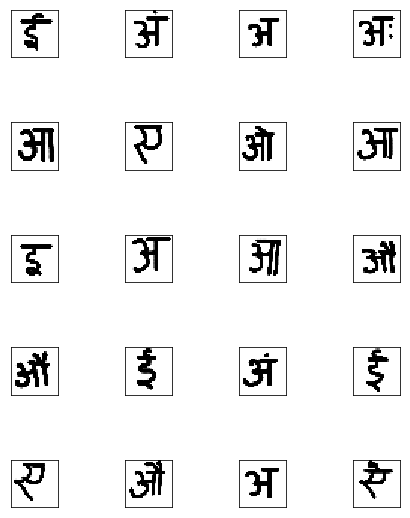

In [82]:
# plot 20 random images from our training set
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 *num_cols, 2*i + 1)
  rand_index = random.randint(1,1756)
  plot_image(rand_index)
plt.show()

# Model Building and training

In [0]:
# let's create a base model
def cnn_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64,(3,3), activation='relu'))
  model.add(Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(layers.Dense(59, activation='softmax'))
  opt = optimizers.Adam(lr=0.0015, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [142]:
model = cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)              0         
__________

In [0]:
# callbacks for saving models
filepath = 'nepali_cnn.h5'
model_save = callbacks.ModelCheckpoint(filepath, monitor= 'val_acc', save_best_only=True)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience =4)

In [0]:
def plot_acc(history):
  plt.plot(history.epoch, history.history['val_acc'] )
  plt.plot(history.epoch, history.history['acc'])
  plt.legend(['val_acc', 'train acc'])


In [145]:
sample_size = train_digits_loader.n
batch_size = 32

hist = model.fit_generator(
    train_digits_loader,
    steps_per_epoch=sample_size // batch_size,
    epochs=50,
    validation_data=test_digits_loader,
    validation_steps=130
)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


54/54 [==============================] - 2s 42ms/step - loss: 3.2585 - acc: 0.0750 - val_loss: 2.6007 - val_acc: 0.1385
Epoch 2/50
54/54 [==============================] - 1s 22ms/step - loss: 2.4928 - acc: 0.1582 - val_loss: 1.6981 - val_acc: 0.4769
Epoch 3/50
54/54 [==============================] - 1s 22ms/step - loss: 1.8022 - acc: 0.3504 - val_loss: 1.2573 - val_acc: 0.5000
Epoch 4/50
54/54 [==============================] - 1s 23ms/step - loss: 1.5469 - acc: 0.4249 - val_loss: 1.1412 - val_acc: 0.5846
Epoch 5/50
54/54 [==============================] - 1s 23ms/step - loss: 1.2951 - acc: 0.5220 - val_loss: 0.8840 - val_acc: 0.6769
Epoch 6/50
54/54 [==============================] - 1s 22ms/step - loss: 1.1400 - acc: 0.5608 - val_loss: 0.7862 - val_acc: 0.7308
Epoch 7/50
54/54 [==============================] - 1s 22ms/step - loss: 1.0383 - acc: 0.5851 - val_loss: 0.7310 - val_acc: 0.6923
Epoch 8/50
54/54 [==============================] - 1s 22ms/step - loss: 0.9720 - acc: 0.6176 

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


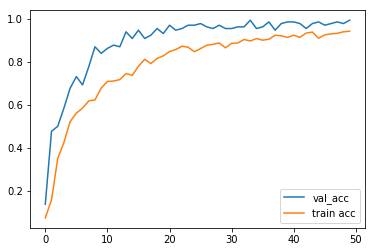

In [146]:
plot_acc(hist)

In [0]:
model.save("nepali_cnn.h5")

# Model loading and evaluation

In [0]:
classifier = models.load_model('nepali_cnn.h5')

In [150]:
classifier.evaluate_generator(test_digits_loader, steps = 130)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


[0.06540396130619355, 0.9769230769230769]

In [151]:
# lets test for our test data
test_digits_loader.reset()
true_labels = test_digits_loader.classes
predictions_with_prob = classifier.predict_generator(test_digits_loader, steps = 130)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [0]:
predictions = np.argmax(predictions_with_prob, axis= 1)

In [0]:
incorrect_predictions = np.nonzero(predictions - true_labels)

In [154]:
incorrect_predictions

(array([ 21, 116]),)

In [155]:
for _ in range(10):
  rand_index = random.randint(0,130)
  print(f'True label: {class_names[true_labels[rand_index]]} , Predicted labe: {class_names[predictions[rand_index]]} for index {rand_index}')

True label: vowel_9_o , Predicted labe: vowel_9_o for index 96
True label: vowel_11_am , Predicted labe: vowel_11_am for index 110
True label: vowel_6_re , Predicted labe: vowel_6_re for index 67
True label: vowel_5_uu , Predicted labe: vowel_5_uu for index 54
True label: vowel_12_ah , Predicted labe: vowel_12_ah for index 129
True label: vowel_4_u , Predicted labe: vowel_4_u for index 49
True label: vowel_10_au , Predicted labe: vowel_10_au for index 109
True label: vowel_7_e , Predicted labe: vowel_7_e for index 75
True label: vowel_5_uu , Predicted labe: vowel_5_uu for index 53
True label: vowel_2_i , Predicted labe: vowel_2_i for index 23


In [0]:
# function to plot image with predictions percentages
def plot_predicted_image(i, predictions_array, true_labels, img_generator):
  predicted_label, true_label, img = predictions_array[i], true_labels[i], img_generator[i][0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  reshaped_img = img.reshape(32,32)
  plt.imshow(reshaped_img, cmap=plt.cm.binary)
  plt.title(f' Predicted {class_names[true_label] } for {class_names[predicted_label]}  digit')


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


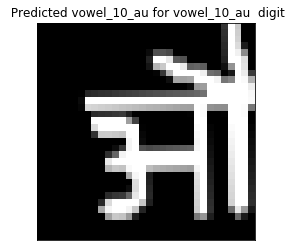

In [157]:
plot_predicted_image(100, predictions, true_labels, test_digits_loader)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


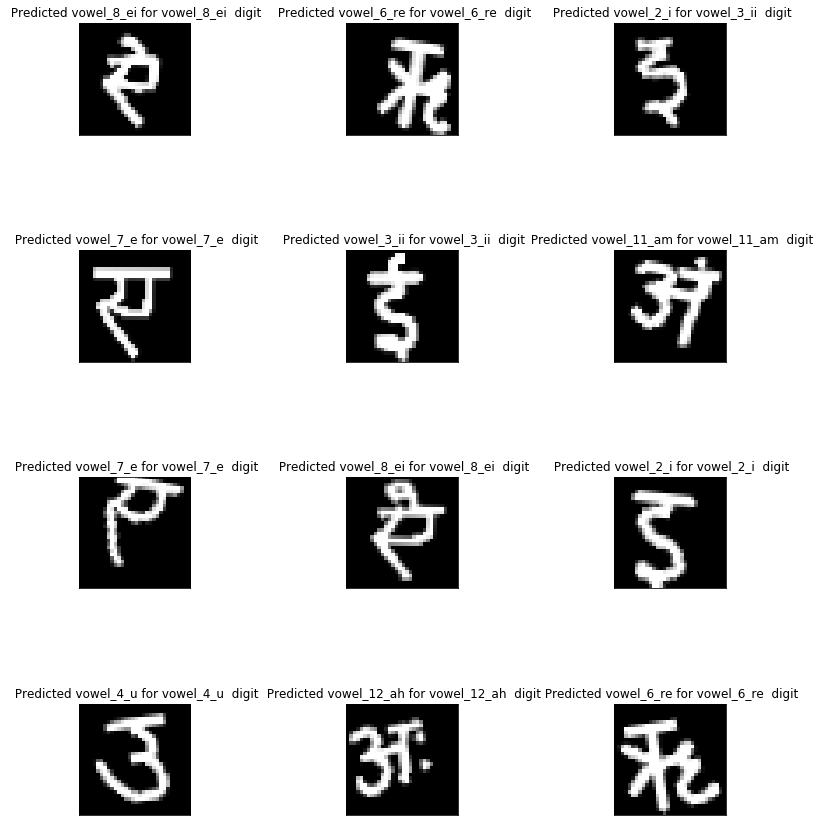

In [174]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols+2, 2*num_rows*+2))
for i in range(num_images):
  plt.subplot(num_rows, 2 *num_cols, 2*i + 1)
  rand_idx = random.randint(0,130)
  plot_predicted_image(rand_idx, predictions, true_labels, test_digits_loader)
plt.show()

In [170]:
incorrect_predictions

(array([ 21, 116]),)

# Let's plot our incorrect prediction

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


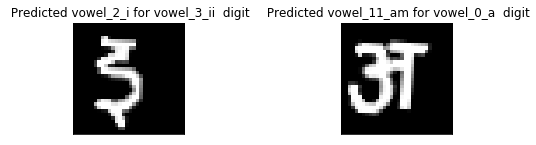

In [175]:
num_rows = 5
num_cols = 3
if(len(incorrect_predictions[0])>num_images):
  num_images = num_rows*num_cols
else:
  num_images = len(incorrect_predictions[0])
  
plt.figure(figsize=(2*2*num_cols+2, 2*num_rows+2))
for i in range(num_images):
  plt.subplot(num_rows, 2 *num_cols, 2*i + 1)
  plot_predicted_image(incorrect_predictions[0][i], predictions, true_labels, test_digits_loader)
plt.show()

It looks like our dataset has some mislabels. We can remove those to get better models.